<a href="https://colab.research.google.com/github/georgie-talukdar/masters/blob/main/Practical_6a_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 6 Classification using SVM

So far we have just been using the datasets provided with sklearn. However, we normally need to use datasets from other locations. So the first part of this practical will give an introduction on how to read in CVS files from a file or URL.

Once you've done this you will need to process the data so that missing values are removed or replaced with sensible values. 

Then finally we can get down to the machine learning. The way you use SVM is very similar to what you did with Logistic Regression - so we don't need to give you all the details for that part. You can just look back at that.

The data: We're going to us the titanic dataset. This dataset contains various features such as the sex of a passenger and the class they were travelling in. The idea is to see if we can predict if the passanger is likely to have survived.

## Reading in the data

Pandas nicely provides you with a method to read in data from a CSV file. The file can either be on your local hard disk or at a URL.

Once you've read in the data the first thing to do is to have a quick look at it - print it out.

In [1]:
import pandas as pd

data = pd.read_csv("http://homepages.cs.ncl.ac.uk/stephen.mcgough/data/titanic.csv")

print(data)

      pclass  survived                                             name  \
0          1         1                    Allen, Miss. Elisabeth Walton   
1          1         1                   Allison, Master. Hudson Trevor   
2          1         0                     Allison, Miss. Helen Loraine   
3          1         0             Allison, Mr. Hudson Joshua Creighton   
4          1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...       ...                                              ...   
1304       3         0                             Zabour, Miss. Hileni   
1305       3         0                            Zabour, Miss. Thamine   
1306       3         0                        Zakarian, Mr. Mapriededer   
1307       3         0                              Zakarian, Mr. Ortin   
1308       3         0                               Zimmerman, Mr. Leo   

         sex     age  sibsp  parch  ticket      fare    cabin embarked boat  \
0     female      29

## What are the different features

We can list the features using the list command

The features are:

| feature | description |
|-----|------|
| pclass | The class the passenger was travelling in |
| survived | Whether the passenger survived or not |
| name | Name of the passenger |
| sex | Gender of the passenger |
| age | Age of the passenger |
| sibsp | Number of siblings or spouses onboard |
| parch | Number of parents or children onboard |
| ticket | Ticket number |
| fare | How much they payed for the ticket |
| cabin | Cabbin number |
| embarked | Where they embarked from (C = Cherbourg; Q = Queenstown; S = Southampton) |
| boat | Lifeboat they got onto |
| body | Unknown |
| home.dest | Where they were eventually travelling to |


In [2]:
list(data)

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home.dest']

We now need to look at each of the features and decide which ones to keep and which ones to delete. You can use the value_counts() method to see how many unique values there are. Below is the one for 'age'.

## Exercise
Try each of the different features and see how many unique values there are and how much missing data there is (recorded here with '?').

Just replace 'age' in the following with each of the features listed above.

In [3]:
data['age'].value_counts()

?         263
24         47
22         43
21         41
30         40
         ... 
66          1
0.6667      1
76          1
67          1
26.5        1
Name: age, Length: 99, dtype: int64

Removing features that either have unique values for all or too much missing data.

We're going to remove the features 'name' and 'ticket' as almost all passengers have a unique name/ticket - so this is unlikely to be of help.

We're going to remove 'cabin', 'boat', 'body' and 'home.dest' as most of these values are missing.

To remove a feature we drop the appropriate column from the pandas dataframe.

In [4]:
dataClean = data.drop(columns=['name', 'cabin', 'ticket', 'boat', 'body', 'home.dest'])

We had two passengers who don't have a record of where they embarked from. We need to set a value for these - let's assume it is Southampton (S). We can come back to this later and try the other options to see if they give us better results.

In [5]:
dataClean['embarked'].replace(['?'], ['S'], inplace=True)

There are a number of passengers missing an age. For now let's assume that they have the median age of all the other passangers. We can again come back to this later and try other estimates.

In [6]:
withoutMissingAge = dataClean.drop(dataClean[dataClean.age=='?'].index)
medianAge = withoutMissingAge['age'].median()
dataClean['age'].replace(['?'], [medianAge], inplace=True)

In the same way there are a number of passangers who don't have a fare value for their travels. We'll again assume that the median is a good estimate. We can come back later and try other estimates.

## Exercise
Using the example of replacing missing ages above replace the missing fares with the median value.

In [7]:
withoutMissingFare = dataClean.drop(dataClean[dataClean.fare=='?'].index) #Delete
medianFare = withoutMissingFare['fare'].median() #Delete
dataClean['fare'].replace(['?'], [medianFare], inplace=True) #Delete

The data should now be clean. We should look at all of the remaining features to check that there are no more missing values.

## Exercise
Check each of the features for missing values. You can do this using values_counts().

Again - replace 'age' with each of the features

In [8]:
dataClean['age'].value_counts()

28.0      263
24         47
22         43
21         41
30         40
         ... 
66          1
0.6667      1
76          1
67          1
26.5        1
Name: age, Length: 99, dtype: int64

The feature 'sex' is a catagorical feature and needs to be converted into a One Hot Encoded set of features. First we use get_dummies() to create a One Hot Encoded version of the feature. But this looses all the other features so we need to join it back to the original data and delete the original feature.

In [9]:
sexOHE = pd.get_dummies(dataClean['sex'], prefix='sex') # prefix is the text to start the new feature names with. The rest of the 
                                                        # feature name will be the catagorical value. So in this case we get
                                                        # sex_female or sex_male
dataClean = dataClean.join(sexOHE)
dataClean = dataClean.drop(columns=['sex'])

We need to do the same for the other catagorical feature - embarked. 

## Exercise
Produce a One Hot encoding for embarked in the same way as sex was done above.

In [10]:
embarkedOHE = pd.get_dummies(dataClean['embarked'], prefix='embarked') # Delete
dataClean = dataClean.join(embarkedOHE) # Delete
dataClean = dataClean.drop(columns=['embarked']) # Delete

## Producing the X and y data

The X data is all of the features without the feature we want to predict and the y data is just the feature we want to predict. 

We can remove the feature we want to predict (survived) from the data to produce X.

We can keep just the feature we want to predict using filter.

In [11]:
X = dataClean.drop(columns=['survived'])
y = dataClean.filter(['survived']).values.ravel() # we need a 1D array for y - hence the need for values.ravel() to reshape the data 

## Split the data

We can now split the data into training and test data.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Now the machine learning

sklearn is really good in the sense that all of the machine learning processes work in prety much the same way:

```
# import the appropriate classifier
from sklearn.linear_model import LogisticRegression

# create an instance of that classifier
logistic = LogisticRegression()

# Train it on our data
logistic.fit(X_train, y_train)
```

So we just need to change sklearn.linear_model.LogisticRegression to sklearn.svm.SVC. Then change the instance you create to the correct classifier.

## Exercises
1. Create a Support Vector Classifer for the titanic data.
2. For your classifier look at the accuracy, precision, recall, F1 and confusion matrix.
3. Look at changing the C value and the kernel for SVC to see if you can improve the results.

# Delete from here

Accuracy(SVC) =  0.6717557251908397
Precision =  0.625
Recall =  0.30612244897959184
f1 =  0.4109589041095891
[[146  18]
 [ 68  30]]


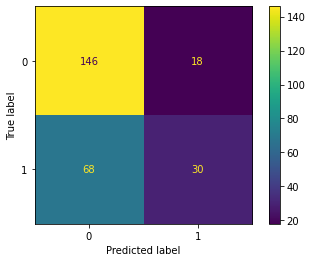

In [13]:
from sklearn.svm import SVC #Delete
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svc = SVC() #Delete

svc.fit(X_train, y_train) #Delete

print('Accuracy(SVC) = ', svc.score(X_test, y_test)) #Delete

# Predict the results:
pred_test = svc.predict(X_test)

print('Precision = ', precision_score(y_test, pred_test))

print('Recall = ', recall_score(y_test, pred_test))

print('f1 = ', f1_score(y_test, pred_test))

# Produce the confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(cm)

# The Confusion matrix as text isn't easy to read - so let's make into a figure
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
display.plot()
plt.show()

To make changing C and kernel easier I've written a function to perform the SVC:

In [14]:
def optimiseSVC(X_train, y_train, X_test, y_test, Cval=1.0, kernelVal = 'rbf'):
  svc = SVC(C=Cval, kernel=kernelVal)
  svc.fit(X_train, y_train) #Delete
  print('Accuracy(SVC) = ', svc.score(X_test, y_test)) #Delete
  # Predict the results:
  pred_test = svc.predict(X_test)
  print('Precision = ', precision_score(y_test, pred_test))
  print('Recall = ', recall_score(y_test, pred_test))
  print('f1 = ', f1_score(y_test, pred_test))
  # Produce the confusion matrix
  cm = confusion_matrix(y_test, pred_test)
  print(cm)
  # The Confusion matrix as text isn't easy to read - so let's make into a figure
  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
  display.plot()
  plt.show() 

We can now vary C and kernel to see what happens.

Valid C = positive numbers 

Valid kernels = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’

There's also ‘precomputed’ and callable - but these require you to provide your own matrix.

Accuracy(SVC) =  0.6717557251908397
Precision =  1.0
Recall =  0.12244897959183673
f1 =  0.2181818181818182
[[164   0]
 [ 86  12]]


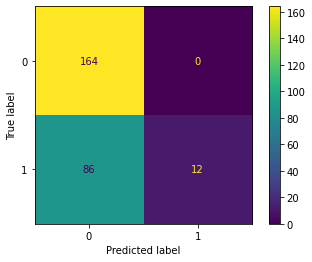

In [15]:
optimiseSVC(X_train, y_train, X_test, y_test, 0.9, 'poly')

You can make a table of results and see which is best.